# Image Classification Project

## Import

In [ ]:
!unzip "/content/drive/MyDrive/ml-data/4geeks-img-classifier/dogs-vs-cats.zip" -d "/content/drive/MyDrive/ml-data/4geeks-img-classifier/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5499.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/55.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/550.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5500.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5501.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5502.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5503.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5504.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5505.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5506.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks-img-classifier/test/5507.jpg  
  inflating: /content/drive/MyDrive/ml-data/4geeks

In [3]:
import warnings

import os
import datetime
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.python.client import device_lib
from keras.callbacks import ModelCheckpoint, EarlyStopping

warnings.filterwarnings('ignore')

In [4]:
print(tf.__version__)
print('GPU', 'Available (YESSSSSS!!!!!!)' if tf.config.list_physical_devices('GPU') else 'Not available :(')
print(tf.config.list_physical_devices())

2.15.0
GPU Available (YESSSSSS!!!!!!)
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
TRAIN_DATA_PATH = '/content/drive/MyDrive/ml-data/4geeks-img-classifier/train'
TEST_DATA_PATH = '/content/drive/MyDrive/ml-data/4geeks-img-classifier/test'

IMG_SIZE = 224
BATCH_SIZE = 32
COLOR_CHANNEL = 3

CHECKPOINT = ModelCheckpoint(
    "/content/drive/MyDrive/ml-data/4geeks-img-classifier/models/vgg16_1.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = "auto"
)
EARLY = EarlyStopping(
    monitor = "val_accuracy",
    patience = 3,
    verbose = 1,
    mode = "auto"
)

In [6]:
def dataset_creation(path):
    labels = []
    filenames = os.listdir(path)

    if 'train' in path:
        print('... Creating training DataFrame ...')
        for file in filenames:
            if 'cat' in file:
                labels.append('cat')
            else:
                labels.append('dog')

        print('... DataFrame Created and Returned ...')
        return pd.DataFrame({
            'images': filenames,
            'labels': labels
        })

    elif 'test' in path:
        print('... Creating testing DataFrame ...')
        return pd.DataFrame(
            {
                'images': os.listdir(path)
            }
        )

In [7]:
train_df = dataset_creation(TRAIN_DATA_PATH)

... Creating training DataFrame ...
... DataFrame Created and Returned ...


In [8]:
train_df.head()

,images,labels
0,cat.9155.jpg,cat
1,cat.9166.jpg,cat
2,cat.9130.jpg,cat
3,cat.9152.jpg,cat
4,cat.9153.jpg,cat


In [9]:
def display_images(imgs, category ,train_data = True, test_data = False, pred_data = False):
    if train_data:
        directory = TRAIN_DATA_PATH
    else:
        directory = TEST_DATA_PATH

    plt.figure(figsize=(10, 8))
    if train_data or pred_data:
        for i, img_name in enumerate(imgs):
            plt.subplot(3, 2, i+1)
            img = mpimg.imread(os.path.join(directory, img_name))
            plt.imshow(img)
            plt.title(img_name)
            plt.axis('off')
    elif test_data:
        for i, img_name in enumerate(imgs):
            plt.subplot(3, 2, i+1)
            img = mpimg.imread(os.path.join(directory, img_name))
            plt.title(i)
            plt.axis('off')

    plt.show()

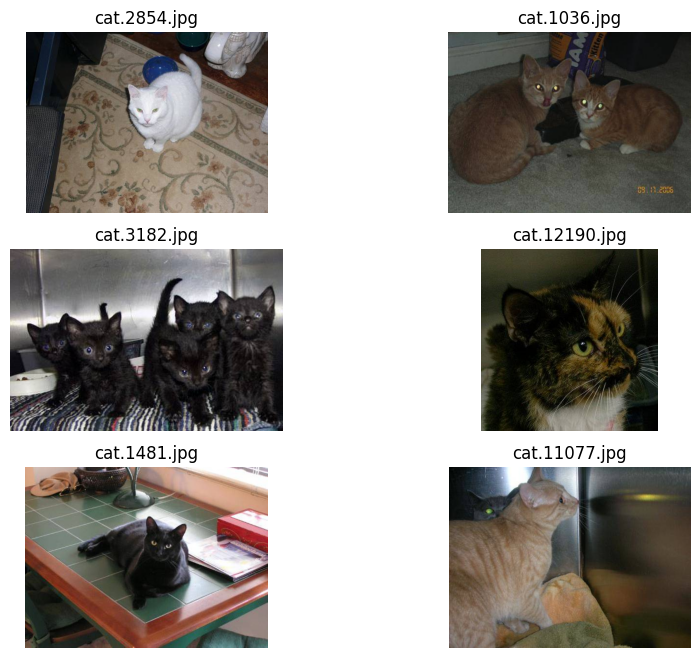

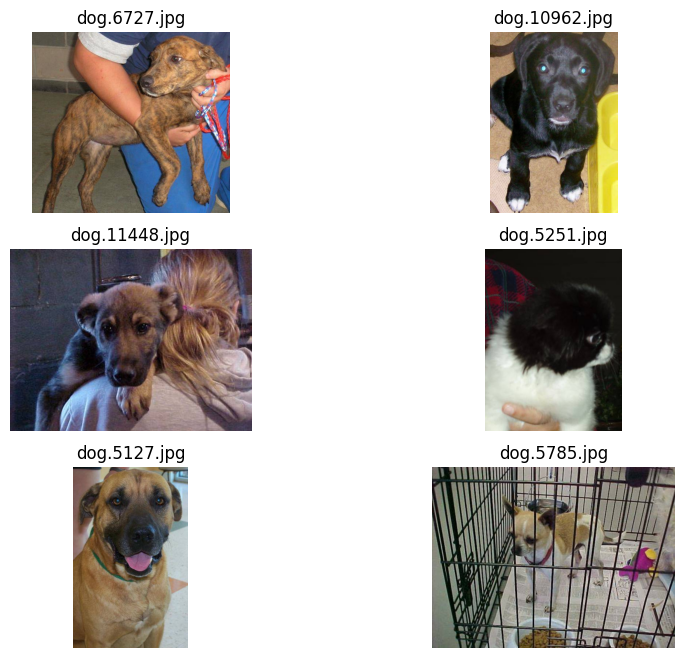

In [10]:
cat_images = random.sample([filename for filename in os.listdir(TRAIN_DATA_PATH) if 'cat' in filename], 6)
dog_images = random.sample([filename for filename in os.listdir(TRAIN_DATA_PATH) if 'dog' in filename], 6)

display_images(
    imgs = cat_images,
    category = 'cat'
)
display_images(
    imgs = dog_images,
    category = 'dog'
)

In [11]:
def prepare_img_generator():
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2
    )

def create_val_data(df, width = IMG_SIZE, height = IMG_SIZE, batchsize = BATCH_SIZE):
    split_data = {
        'train_data': prepare_img_generator().flow_from_dataframe(
            dataframe = df,
            directory = TRAIN_DATA_PATH,
            x_col = 'images',
            y_col = 'labels',
            target_size = (IMG_SIZE, IMG_SIZE),
            batch_size = BATCH_SIZE,
            class_mode = 'binary',
            subset = 'training'
        ),
        'val_data': prepare_img_generator().flow_from_dataframe(
            dataframe = df,
            directory = TRAIN_DATA_PATH,
            x_col = 'images',
            y_col = 'labels',
            target_size = (width, height),
            batch_size = batchsize,
            class_mode = 'binary',
            subset = 'validation'
        )
    }

    return split_data['train_data'], split_data['val_data']

In [12]:
train_data, val_data = create_val_data(train_df)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [13]:
def load_base_model(tunning, width = IMG_SIZE, height = IMG_SIZE, channels = COLOR_CHANNEL):
    print('Loading the base model ready for fine-tunning...' if tunning else 'Loading the base model...')
    base_model = VGG16(
        weights = 'imagenet',
        include_top = False,
        input_shape = (width, height, channels)
    )

    if tunning:
        for layer in base_model.layers[-10:]:
            layer.trainable = tunning
    else:
        for layer in base_model.layers:
            layer.trainable = tunning

    return base_model

In [14]:
def custom_model(tuned = False):
    base_model = load_base_model(tunning = tuned)

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

    return tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

In [15]:
model = custom_model()
model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.0001
    ),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Loading the base model...
58889256/58889256 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
history = model.fit(
    train_data,
    steps_per_epoch = len(train_data),
    validation_data = val_data,
    validation_steps = len(val_data),
    epochs = 10,
    callbacks = [EARLY]
)

Epoch 1/10
369/625 [================>.............] - ETA: 52:49 - loss: 0.2743 - accuracy: 0.8800

KeyboardInterrupt: 

In [ ]:
def evaluate_model(m):
    plt.plot(m.history['accuracy'], label = 'Training Accuracy')
    plt.plot(m.history['val_accuracy'], label = 'Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc = 'lower right')
    plt.title('Model Accuracy over Epochs')

    plt.show()

In [ ]:
evaluate_model(history)

In [ ]:
tuned_model = custom_model(tuned = True)

tuned_model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.0001
    ),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = tuned_model.fit(
    train_data,
    steps_per_epoch = train_data.samples // BATCH_SIZE,
    validation_data = val_data,
    validation_steps = val_data.samples // BATCH_SIZE,
    epochs = 10,
    callbacks = [EARLY, CHECKPOINT]
)

In [ ]:
evaluate_model(history)

In [ ]:
test_df = dataset_creation(TEST_DATA_PATH)
test_df.head()

In [ ]:
test_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
).flow_from_dataframe(
    dataframe = test_df,
    directory = TEST_DATA_PATH,
    x_col = 'images',
    y_col = None,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None
)

In [ ]:
test1_predict = tuned_model.predict(test_data)

In [ ]:
threshold = 0.5

test_df['labels'] = np.where(
    test1_predict > threshold,
    'dog',
    'cat'
)

In [ ]:
test_df['num_label'] = test_data['labels'].replace(
    {
        'dog': 1,
        'cat': 0
    }
)

In [ ]:
test_df.tail()

In [ ]:
sample_test = test_df.sample(n=6)
plt.figure(figsize=(10, 8))

subplot_index = 1
for _, row in sample_test.iterrows():
    image_path = os.path.join(TEST_DATA_PATH, row['images'])
    img = mpimg.imread(image_path)
    plt.subplot(2, 3, subplot_index)
    plt.imshow(img)
    plt.title(row['images']) # Change to 'labels' or 'num_label'
    plt.axis('off')
    subplot_index += 1

plt.show()